In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Playlist

In [45]:
df = pd.read_csv('output.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [46]:
df['playlist_number'] = df['playlist'].replace(['Descanso', 'Reggaetón', 'Despecho', 'English', 'English Metal',
       'Random', 'Rap', 'Salsa', 'Soft', 'Spanish', 'Metal en español', 'Vallenato'],[0,1,2,3,4,5,6,7,8,9,10,11])

In [47]:
column_order = ['playlist','playlist_number', 'name', 'artist', 'albumreleasedate', 'genres', 'energy',
       'danceability', 'loudness', 'speechiness', 'acousticness', 'liveness',
       'trackpopularity']
df = df[column_order]

In [48]:
# playlist_by_genre = df.groupby('playlist')['genres'].apply(lambda x: x.explode().value_counts().nlargest(10))
# genres = playlist_by_genre.index.get_level_values(1)
# genres

In [49]:
columns = ['playlist_number','energy', 'danceability',
       'loudness', 'speechiness', 'acousticness', 'liveness', 'trackpopularity']

In [50]:
df_corr = df[columns]

In [51]:
df_corr.head()

,playlist_number,energy,danceability,loudness,speechiness,acousticness,liveness,trackpopularity
0,0,0.309,0.550,-12.575,0.0410,0.911,0.0693,41
1,0,0.172,0.610,-14.957,0.0330,0.892,0.1010,54
2,0,0.206,0.783,-10.016,0.0663,0.906,0.1090,53
3,0,0.216,0.627,-15.371,0.0328,0.930,0.1220,52
4,0,0.270,0.478,-14.107,0.0468,0.486,0.1100,35


In [52]:
matrix = df_corr.corr()

In [53]:
matrix

,playlist_number,energy,danceability,loudness,speechiness,acousticness,liveness,trackpopularity
playlist_number,1.000000,0.528376,-0.129936,0.485407,-0.020548,-0.416261,0.095086,-0.053482
energy,0.528376,1.000000,-0.067508,0.838209,0.165524,-0.761900,0.122183,0.117605
danceability,-0.129936,-0.067508,1.000000,0.085907,0.138264,0.081625,-0.050353,0.006178
loudness,0.485407,0.838209,0.085907,1.000000,0.156727,-0.656376,0.109820,0.126312
speechiness,-0.020548,0.165524,0.138264,0.156727,1.000000,-0.172347,0.004688,0.150065
acousticness,-0.416261,-0.761900,0.081625,-0.656376,-0.172347,1.000000,-0.115200,-0.219042
liveness,0.095086,0.122183,-0.050353,0.109820,0.004688,-0.115200,1.000000,0.029647
trackpopularity,-0.053482,0.117605,0.006178,0.126312,0.150065,-0.219042,0.029647,1.000000


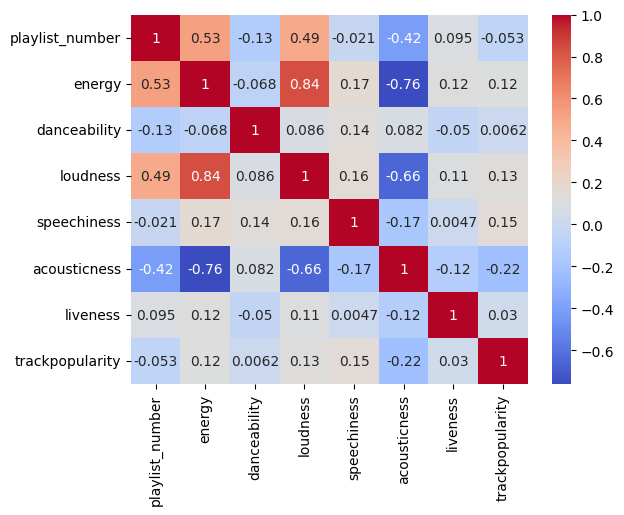

In [54]:
sns.heatmap(matrix, annot=True, cmap='coolwarm');

In [55]:
# Create ML columns 
variable_columns = df.drop(['playlist','name', 'artist', 'albumreleasedate', 'genres'],axis = 1)

# K Means Clustering

In [56]:
from sklearn.preprocessing import MinMaxScaler    
from sklearn.cluster import KMeans


In [57]:
scaler = MinMaxScaler()
scaled_columns = scaler.fit_transform(variable_columns)


In [58]:
wcss = []


In [59]:
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(scaled_columns)
    wcss.append(kmeans.inertia_)


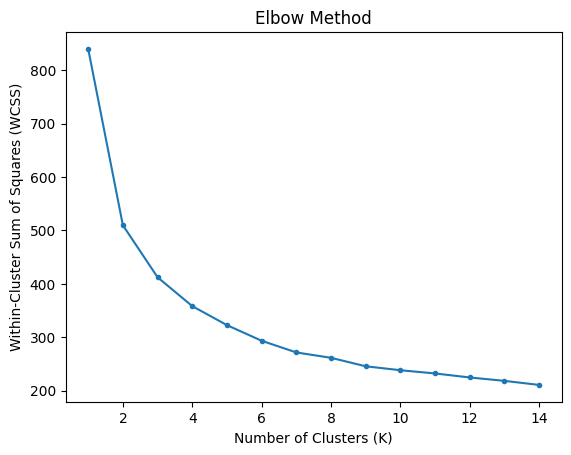

In [60]:
plt.plot(range(1, 15), wcss, '.-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()


In [61]:
# I am choosing the amount of clusters by using the elbow method (I chose 7 initially)

kmeans = KMeans(n_clusters=7, n_init=10)
clusters = kmeans.fit_predict(scaled_columns)

In [62]:
df["music_segments"] = clusters
MinMaxScaler(df["music_segments"])
df["music_segments"] = df["music_segments"].map({0: "Cluster 1", 1: 
    "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5", 
    5: "Cluster 6", 6: "Cluster 7"})

In [63]:
import plotly.graph_objects as go
PLOT = go.Figure()
for i in list(df["music_segments"].unique()):
    PLOT.add_trace(go.Scatter3d(x = df[df["music_segments"]== i]['energy'],
                                y = df[df["music_segments"] == i]['loudness'],
                                z = df[df["music_segments"] == i]['acousticness'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(i)))
PLOT.update_traces(hovertemplate='energy: %{x} <br>loudness: %{y} <br>acousticness: %{z}')

    
PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'energy', titlefont_color = 'black'),
                                yaxis=dict(title = 'loudness', titlefont_color = 'black'),
                                zaxis=dict(title = 'acousticness', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))



In [64]:
df['music_segments'].value_counts()

music_segments
Cluster 2    516
Cluster 1    358
Cluster 3    243
Cluster 4    234
Cluster 5    208
Cluster 7    151
Cluster 6    140
Name: count, dtype: int64

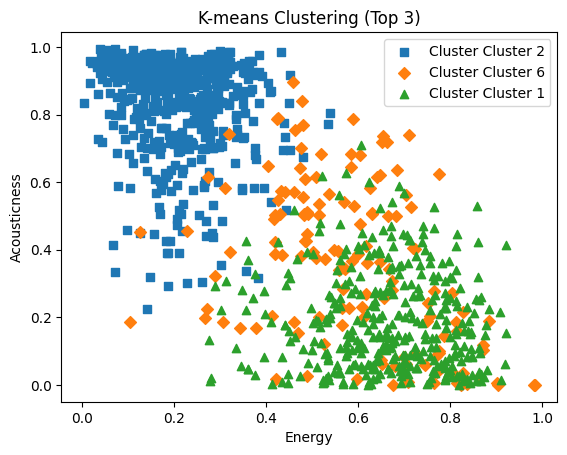

In [65]:
# Define marker styles for each cluster
marker_styles = ['s', 'D', '^', 'v', 'P', 'X', '*']

# Create the scatter plot
for cluster_label, marker_style in zip(df["music_segments"].unique()[:3], marker_styles):
    cluster_data = df[df["music_segments"] == cluster_label]
    plt.scatter(
        x=cluster_data['energy'],
        y=cluster_data['acousticness'],
        marker=marker_style,
        label=f'Cluster {cluster_label}'
    )

# Set the labels and title of the plot
plt.xlabel('Energy')
plt.ylabel('Acousticness')
plt.title('K-means Clustering (Top 3)')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [66]:
df.groupby('music_segments')['playlist_number'].value_counts().nlargest(10)

music_segments  playlist_number
Cluster 2       0                  484
Cluster 1       1                  213
Cluster 5       4                   96
                3                   83
Cluster 3       7                   70
                5                   66
Cluster 6       2                   62
Cluster 4       9                   61
                10                  60
Cluster 7       7                   55
Name: count, dtype: int64

####  Note that Cluster with the most songs from the same playlist is the one with the most quantity of songs from the playlist name is *Descanso*, and it is about lo-fi hip hop for studying and sleeping, thus they are closely related one to another, followed by *Reggaetón* being all about latin music and reggaetón.

# K Nearest Neighbors 

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV



### variable_columns is the DataFrame containing only numerical values from the original data

In [68]:
X = variable_columns.drop(['playlist_number'], axis = 1)

In [69]:
X.head()

,energy,danceability,loudness,speechiness,acousticness,liveness,trackpopularity
0,0.309,0.550,-12.575,0.0410,0.911,0.0693,41
1,0.172,0.610,-14.957,0.0330,0.892,0.1010,54
2,0.206,0.783,-10.016,0.0663,0.906,0.1090,53
3,0.216,0.627,-15.371,0.0328,0.930,0.1220,52
4,0.270,0.478,-14.107,0.0468,0.486,0.1100,35


In [70]:
y = variable_columns['playlist_number']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [72]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)


In [73]:
model = KNeighborsClassifier()
model.fit(train_scaled, y_train);


In [74]:
mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))

In [75]:
from math import sqrt
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))


mse =  8.001351351351351  & mae =  1.3891891891891892  & rmse =  2.828666002084967


In [76]:
test_mse = mean_squared_error(y_test, model.predict(test_scaled))
test_mae = mean_absolute_error(y_test, model.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  11.37027027027027  & mae =  1.9486486486486487  & rmse =  3.3719831361189025


### Now i will apply GridSearch to try and find the best possible fit 

In [77]:
knn = KNeighborsClassifier()
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [78]:
print(grid_search.best_params_)


{'n_neighbors': 11}


In [79]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.4081081081081081
Precision: 0.3660843908048769
Recall: 0.4081081081081081
F1-score: 0.3740377194255719
